In [63]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rasterio
import sys
import os

sys.path.append('/home/esther/lc-mapping/scripts/')
import landcover_definitions as lc
import general_prior_calculation as make_prior
#import enviroatlas_data_processing as data_processing
import util
from importlib import reload
import sklearn.preprocessing
import torch as T
device=T.device('cuda:0')
reload(lc)

Populating the interactive namespace from numpy and matplotlib


<module 'landcover_definitions' from '/home/esther/lc-mapping/scripts/landcover_definitions.py'>

In [64]:
classes_keep = [1,2,3,4,6]

def reindex_ea(array_in, classes_keep):
    ignore_index = len(classes_keep)
    reindex_map = dict(zip(classes_keep, np.arange(len(classes_keep))))
    # reindex shrub to tree
    tree_idx = 3 # tree idx is 3 when there are no zeros
    shrub_idx = 5
    reindexed_mask = -1 * np.ones(array_in.shape)
    for old_idx, new_idx in reindex_map.items():
        reindexed_mask[array_in == old_idx] = new_idx

    reindexed_mask[reindexed_mask == -1] = ignore_index

    return reindexed_mask

colors = [lc.lc_colors['enviroatlas'][c] for c in classes_keep]

In [65]:
tile_ids = np.unique([x[:10] for x in os.listdir('/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/')])

In [66]:
fn = '/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/3311127_sw_prior_from_cooccurrences_101_31_no_osm_no_buildings.tif'

In [67]:
fn = '/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/3311127_sw_prior_from_cooccurrences_101_31_no_osm_no_buildings.tif'

In [68]:
tile_id= '3311127_sw'
image_fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_a_naip.tif'
#learned_prior_fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}learned_prior_101_31.tif'
prior_fn = fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_prior_from_cooccurrences_101_31_no_osm_no_buildings.tif'

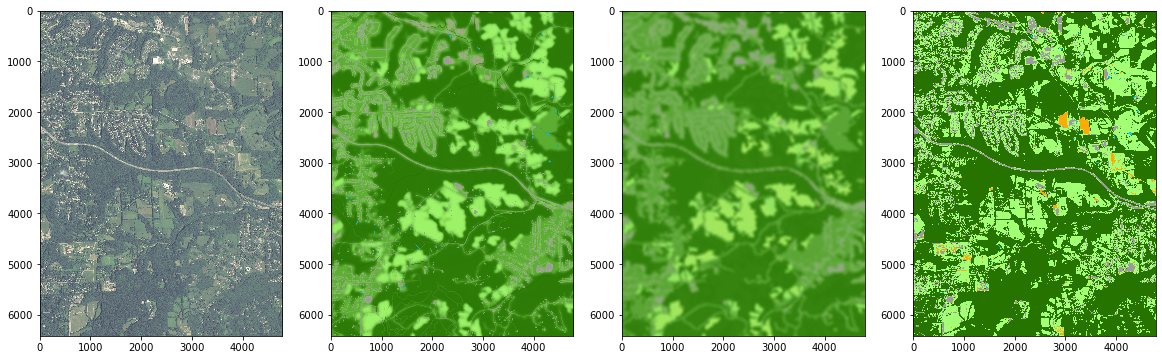

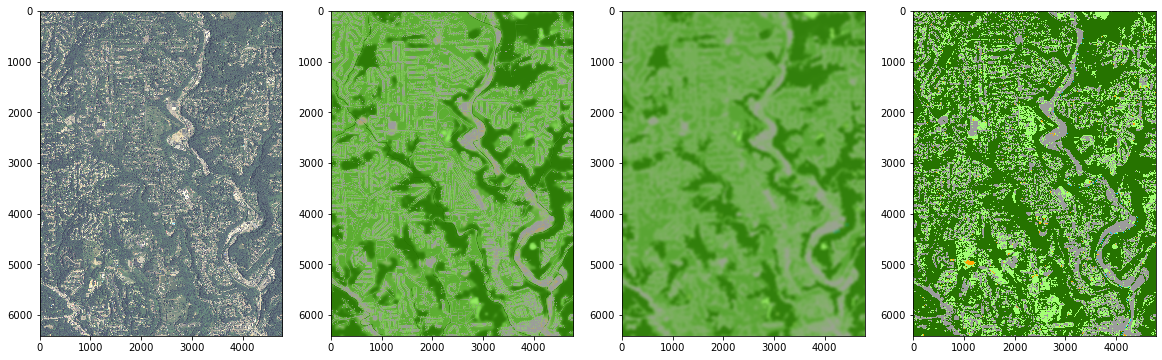

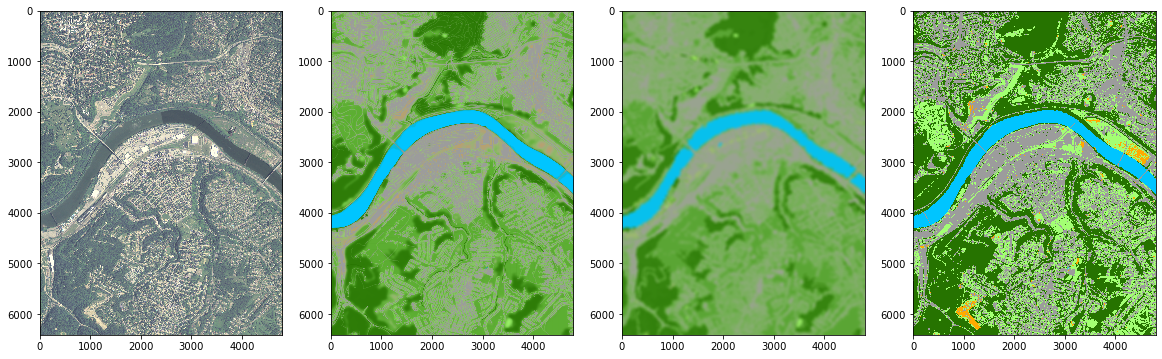

In [73]:
state = 'phoenix_az-2010_1m'
states = [#'durham_nc-2012_1m', 
          #'austin_tx-2012_1m',
          'pittsburgh_pa-2010_1m']
for state in states:
    tile_ids = np.unique([x[:10] for x in os.listdir(f'/home/esther/torchgeo_data/enviroatlas/{state}-val_tiles-debuffered/')])

    for tile_id in tile_ids[:3]:

        image_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-val_tiles-debuffered/{tile_id}_a_naip.tif'
        learned_prior_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-val_tiles-debuffered/{tile_id}_prior_learned_101_31.tif'
        prior_fn  = f'/home/esther/torchgeo_data/enviroatlas/{state}-val_tiles-debuffered/{tile_id}_prior_from_cooccurrences_101_31_no_osm_no_buildings.tif'
        label_fn = f'/home/esther/torchgeo_data/enviroatlas/{state}-val_tiles-debuffered/{tile_id}_h_highres_labels.tif'

        learned_prior = rasterio.open(learned_prior_fn).read()
        handmade_prior = rasterio.open(prior_fn).read()
        img = rasterio.open(image_fn).read()
        h = lc.map_raw_lc_to_idx['enviroatlas'][rasterio.open(label_fn).read()[0]]

        h_copy = h.copy()
        for i, cls in enumerate(classes_keep):
            h_copy[h == cls] = i

        fig, ax = plt.subplots(1,4, figsize=(20,8))
        ax[0].imshow(img[:3].T.swapaxes(0,1),interpolation='none')
        ax[1].imshow(lc.vis_lc_from_colors(learned_prior, colors).T.swapaxes(0,1),interpolation='none')
        ax[2].imshow(lc.vis_lc_from_colors(handmade_prior, colors).T.swapaxes(0,1),interpolation='none')
        ax[3].imshow(lc.vis_lc_from_colors(h_copy, colors).T.swapaxes(0,1),interpolation='none')
        plt.show()

In [57]:
learned_prior[:,0,0]

array([  7, 142,  52,  31,  20], dtype=uint8)

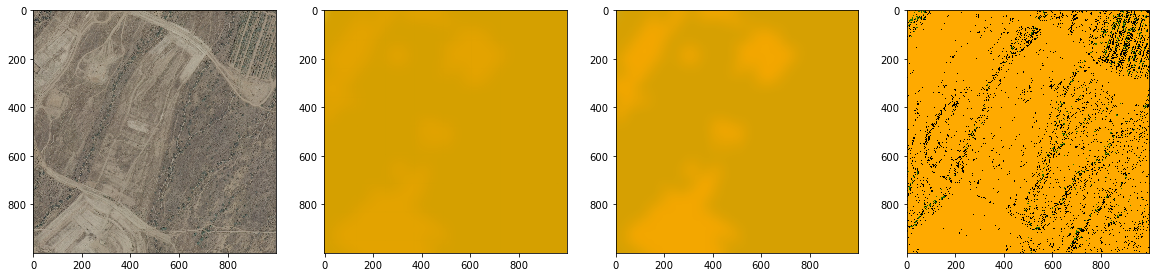

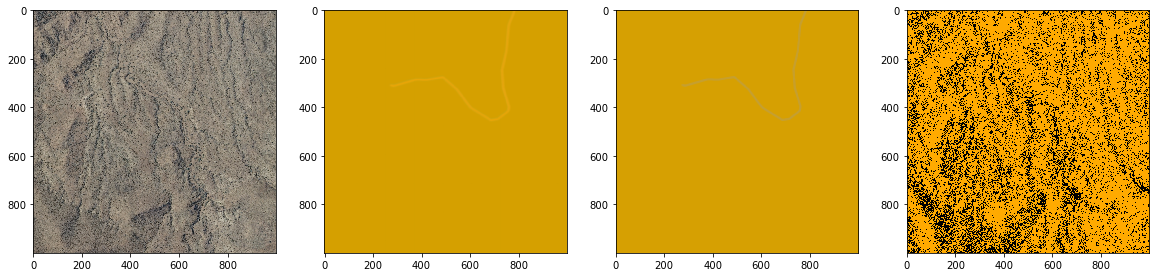

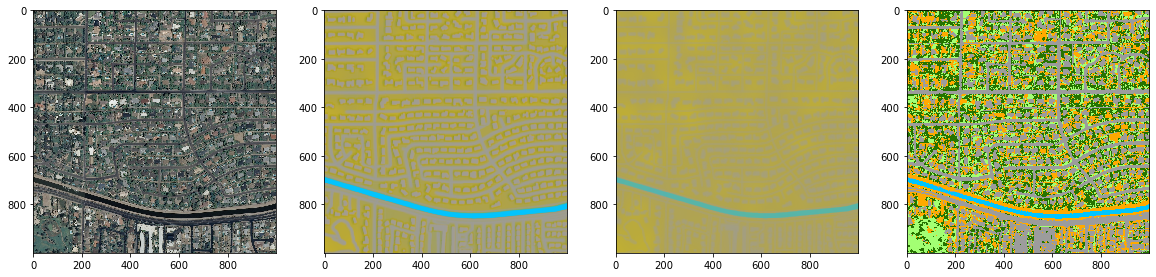

In [62]:
h1, h2 = 0, 1000
w1, w2 = 4000, 5000

for tile_id in tile_ids[:3]:
    
    image_fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_a_naip.tif'
    learned_prior_fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_prior_learned_101_31.tif'
    prior_fn  = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_prior_from_cooccurrences_101_31.tif'
    label_fn = f'/home/esther/torchgeo_data/enviroatlas/phoenix_az-2010_1m-test_tiles-debuffered/{tile_id}_h_highres_labels.tif'

    learned_prior = rasterio.open(learned_prior_fn).read()
    handmade_prior = rasterio.open(prior_fn).read()
    img = rasterio.open(image_fn).read()
    h = lc.map_raw_lc_to_idx['enviroatlas'][rasterio.open(label_fn).read()[0]]
    
    h_copy = h.copy()
    for i, cls in enumerate(classes_keep):
        h_copy[h == cls] = i

    fig, ax = plt.subplots(1,4, figsize=(20,8))
    ax[0].imshow(img[:3,h1:h2,w1:w2].T.swapaxes(0,1),interpolation='none')
    ax[1].imshow(lc.vis_lc_from_colors(learned_prior[:,h1:h2,w1:w2], colors).T.swapaxes(0,1),interpolation='none')
    ax[2].imshow(lc.vis_lc_from_colors(handmade_prior[:,h1:h2,w1:w2], colors).T.swapaxes(0,1),interpolation='none')
    ax[3].imshow(lc.vis_lc_from_colors(h_copy[h1:h2,w1:w2], colors).T.swapaxes(0,1),interpolation='none')
    plt.show()

In [52]:
 np.rollaxis(np.dstack((np.ones((4,4,1)), np.zeros((4,4,1)))),0,3).shape

(4, 2, 4)